# <font style="color:blue">Project 2: Kaggle Competition - Classification</font>

#### Maximum Points: 100

<div>
    <table>
        <tr><td><h3>Sr. no.</h3></td> <td><h3>Section</h3></td> <td><h3>Points</h3></td> </tr>
        <tr><td><h3>1</h3></td> <td><h3>Data Loader</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3>Configuration</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>3</h3></td> <td><h3>Evaluation Metric</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>4</h3></td> <td><h3>Train and Validation</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>5</h3></td> <td><h3>Model</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>6</h3></td> <td><h3>Utils</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>7</h3></td> <td><h3>Experiment</h3></td><td><h3>5</h3></td> </tr>
        <tr><td><h3>8</h3></td> <td><h3>TensorBoard Log</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>9</h3></td> <td><h3>Kaggle Profile Link</h3></td> <td><h3>50</h3></td> </tr>
    </table>
</div>


## <font style="color:green">1. Data Loader [10 Points]</font>

In this section, you have to write a class or methods, which will be used to get training and validation data loader.

You need to write a custom dataset class to load data.

**Note; There is   no separate validation data. , You will thus have to create your own validation set, by dividing the train data into train and validation data. Usually, we do 80:20 ratio for train and validation, respectively.**


For example:

```python
class KenyanFood13Dataset(Dataset):
    """
    
    """
    
    def __init__(self, *args):
    ....
    ...
    
    def __getitem__(self, idx):
    ...
    ...
    
    
```

```
def get_data(args1, *agrs):
    ....
    ....
    return train_loader, test_loader
```

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt  # one of the best graphics library for python
plt.style.use('ggplot')

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.transforms import functional as Fn
from torchvision import datasets, transforms, models


import matplotlib.pyplot as plt

import os
import numpy as np
import pandas as pd
import time

from typing import Callable, Iterable
from dataclasses import dataclass

from torchvision.transforms import ToTensor
from torchvision import datasets, transforms, models
from torchvision.models import resnet18, ResNet18_Weights

from torch.optim import lr_scheduler


from PIL import Image

# %matplotlib notebook
# %load_ext autoreload
# %autoreload 2

from operator import itemgetter
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter

2025-02-19 15:52:46.435678: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740009166.448939  230884 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740009166.453214  230884 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-19 15:52:46.466881: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
class KenyanFood13Dataset(Dataset):
    """
    This custom dataset class takes root directory and train flag, 
    and returns dataset training dataset if train flag is true 
    else it returns validation dataset.
    """
    
    def __init__(self, data_root, image_shape=None, transform=None):
        
        """
        init method of the class.
        
         Parameters:
         
         data_root (string): path of root directory.
         
         image_shape (int or tuple or list): [optional] int or tuple or list. Defaut is None. 
                                             If it is not None image will resize to the given shape.
                                 
         transform (method): method that will take PIL image and transform it.
         
        """
        
        # get label to species mapping
        label_csv_path = os.path.join(data_root, 'train.csv')
        self.data_df = pd.read_csv(label_csv_path, delimiter=' *, *', engine='python')
        self.classes = self.data_df.iloc[:, 1].unique()
        self.num_classes = len(self.classes)
        self.image_ids = self.data_df.iloc[:, 0]

        self.class_given_label = {image_id : image_class for image_id, image_class in enumerate(self.classes)}
        self.label_given_class = {image_class : image_id for image_id, image_class in enumerate(self.classes)}

        
        # set image_resize attribute
        if image_shape is not None:
            if isinstance(image_shape, int):
                self.image_shape = (image_shape, image_shape)
            
            elif isinstance(image_shape, tuple) or isinstance(image_shape, list):
                assert len(image_shape) == 1 or len(image_shape) == 2, 'Invalid image_shape tuple size'
                if len(image_shape) == 1:
                    self.image_shape = (image_shape[0], image_shape[0])
                else:
                    self.image_shape = image_shape
            else:
                raise NotImplementedError 
                
        else:
            self.image_shape = image_shape
            
        # set transform attribute
        self.transform = transform

        # initialize the data dictionary
        self.data_dict = {
            'image_path': [],
            'label': []
        }
        img_dir = os.path.join(data_root, 'images', 'images')

        # print("self.data_df", type(self.data_df))
        for data in self.data_df.iterrows():
            image_id = str(data[1]['id']) + '.jpg'
            image_path = os.path.join(img_dir, image_id)
            image_class = data[1]['class']
            label = self.label_given_class[image_class]
            self.data_dict['image_path'].append(image_path)
            self.data_dict['label'].append(label)
        
    def __len__(self):
        """
        return length of the dataset
        """
        return len(self.data_dict['label'])
    
    def __getitem__(self, idx):
        """
        For given index, return images with resize and preprocessing.
        """
        image = Image.open(self.data_dict['image_path'][idx]).convert("RGB")
        
        if self.image_shape is not None:
            image = Fn.resize(image, self.image_shape)
            
        if self.transform is not None:
            image = self.transform(image)
            
            
        target = self.data_dict['label'][idx]
        
        return image, target            
                
        
    def class_name(self, label):
        """
        class label to common name mapping
        """
        return self.class_given_label[label]

Length of the dataset: 6536
(256, 256)
Label: 4, class name: sukumawiki


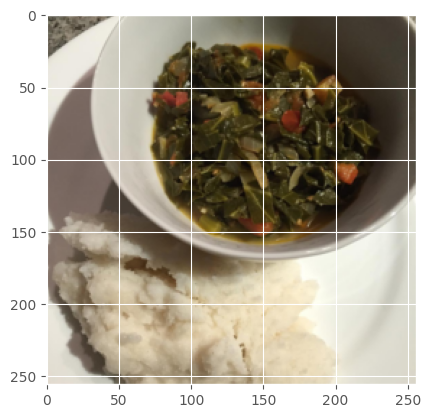

In [4]:
# data root directory
# data_root = '../resource/lib/publicdata/images/10-monkey-species'
data_root = '../../../../data/Week7_project2_classification/KenyanFood13Dataset'

dataset =  KenyanFood13Dataset(data_root, image_shape=256)

print('Length of the dataset: {}'.format(len(dataset)))

img, trgt = dataset[300]
print(img.size)
print('Label: {}, class name: {}'.format(trgt, dataset.class_name(trgt)))
plt.imshow(img)
plt.show()


In [5]:
# def get_mean_std(batch_data):
    
#     # transform = image_preprocess_transforms()
    
#     # loader = data_loader(data_root, transform)
    
#     # batch_mean = torch.zeros(3)
#     # batch_mean_sqrd = torch.zeros(3)

#     # for batch_data, _ in loader:
#     #     batch_mean += batch_data.mean(dim=(0, 2, 3)) # E[batch_i] 
#     #     batch_mean_sqrd += (batch_data ** 2).mean(dim=(0, 2, 3)) #  E[batch_i**2]
    
#     # # E[dataset] = E[E[batch_1], E[batch_2], ...]
#     # mean = batch_mean / len(loader)
    
#     # # var[X] = E[X**2] - E[X]**2
    
#     # # E[X**2] = E[E[batch_1**2], E[batch_2**2], ...]
#     # # E[X]**2 = E[E[batch_1], E[batch_2], ...] ** 2
    
#     # var = (batch_mean_sqrd / len(loader)) - (mean ** 2)
        
#     # std = var ** 0.5
#     mean=[0.5, 0.5, 0.5]
#     std=[0.5, 0.5, 0.5]
#     print('mean: {}, std: {}'.format(mean, std))
    
#     return mean, std

In [6]:
def image_common_transforms(mean, std):
    # preprocess = image_preprocess_transforms()
    
    common_transforms = transforms.Compose([
        # preprocess,
        transforms.Normalize(mean, std)
    ])
    
    return common_transforms


In [7]:
# def get_data(batch_size, train_dataset, num_workers=4, data_augmentation=False):
#     # YOUR CODE HERE
#     # common transforms
#     # train_data_path = os.path.join(data_root, 'training')
#     # mean, std = get_mean_std(data_root=train_data_path, num_workers=num_workers)
#     mean=[0.5, 0.5, 0.5]
#     std=[0.5, 0.5, 0.5]
#     common_transforms = image_common_transforms(mean, std)
    
#     # if data_augmentation is true 
#     # data augmentation implementation
#     if data_augmentation:
#         train_transforms = transforms.Compose([
#             transforms.RandomChoice([
#                 transforms.RandomHorizontalFlip(),
#                 transforms.RandomVerticalFlip(),
#                 transforms.RandomRotation(20),
#                 transforms.RandomCrop(28, padding=4),
#                 # transforms.PILToTensor(),
#                 # transforms.ConvertImageDtype(torch.float),
#                 transforms.RandomPerspective(distortion_scale=0.6, p=1),
#                 transforms.ColorJitter(brightness=.5, hue=.3)
#             ]),
#             common_transforms
#         ])
#     # else do common transforms
#     else:
#         train_transforms = common_transforms
        
#     print("get_data() - train_dataset", type(train_dataset))
#     # dataset = datasets.ImageFolder(root=train_dataset, transform=train_transforms)
    
#     # loader = torch.utils.data.DataLoader(dataset, 
#     #                                      batch_size=batch_size,
#     #                                      num_workers=num_workers,
#     #                                      shuffle=shuffle)
    
#     # train_loader = torch.utils.data.DataLoader(
#     #     train_dataset,
#     #     batch_size=15,
#     #     shuffle=True,
#     #     num_workers=2
#     # )
        
#     # train dataloader
#     # train_loader = data_loader(train_data_path, 
#     #                            train_transforms, 
#     #                            batch_size=batch_size, 
#     #                            shuffle=True, 
#     #                            num_workers=num_workers)
    
#     # test dataloader
    
#     # test_data_path = os.path.join(data_root, 'validation')
    
#     # test_loader = data_loader(test_data_path, 
#     #                           train_transforms, 
#     #                           batch_size=batch_size, 
#     #                           shuffle=False, 
#     #                           num_workers=num_workers)
    
#     # return train_loader

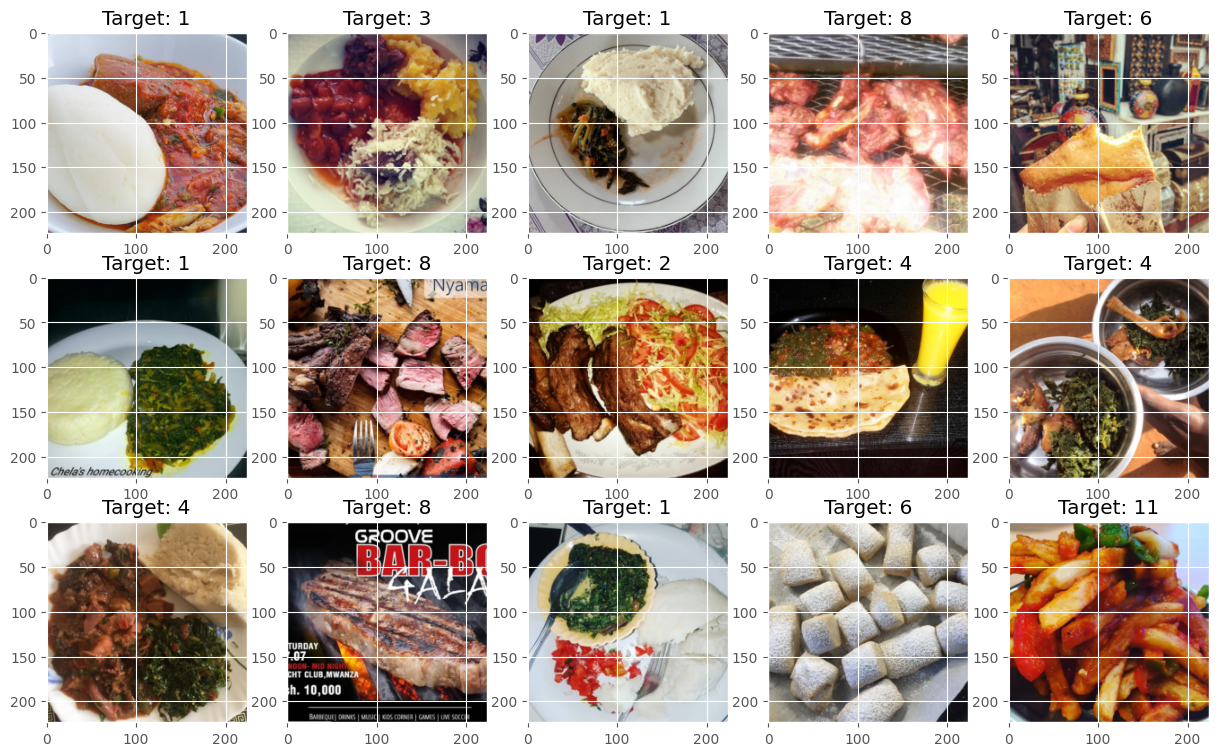

In [8]:

compulsary_preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
    ])

dataset =  KenyanFood13Dataset(data_root, image_shape=None, transform=compulsary_preprocess)

train_size = int(0.8 * len(dataset)) # 80% for training
validation_size = len(dataset) - train_size # 20% for validation

train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])

# dataloader with dataset
validation_loader = torch.utils.data.DataLoader(
        validation_dataset,
        batch_size=15,
        shuffle=True,
        num_workers=2
    )


# Plot few images
plt.rcParams["figure.figsize"] = (15, 9)
plt.figure
for images, labels in validation_loader:
    for i in range(len(labels)):
        plt.subplot(3, 5, i+1)
        img = Fn.to_pil_image(images[i])
        plt.imshow(img)
        plt.gca().set_title('Target: {0}'.format(labels[i]))
    plt.show()
    break

In [9]:
from torch.utils.data import Dataset

class TransformedSubset(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        image, label = self.subset[idx]  # Get item from subset
        if self.transform:
            image = self.transform(image)  # Apply transformation
        return image, label

In [14]:
def get_mean_std(dataset, batch_size=8, num_workers=4):
    
    # transform = image_preprocess_transforms()
    
    # loader = data_loader(data_root, transform)
    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )
    
    batch_mean = torch.zeros(3)
    batch_mean_sqrd = torch.zeros(3)

    for batch_data, _ in loader:
        batch_mean += batch_data.mean(dim=(0, 2, 3)) # E[batch_i] 
        batch_mean_sqrd += (batch_data ** 2).mean(dim=(0, 2, 3)) #  E[batch_i**2]
    
    # E[dataset] = E[E[batch_1], E[batch_2], ...]
    mean = batch_mean / len(loader)
    
    # var[X] = E[X**2] - E[X]**2
    
    # E[X**2] = E[E[batch_1**2], E[batch_2**2], ...]
    # E[X]**2 = E[E[batch_1], E[batch_2], ...] ** 2
    
    var = (batch_mean_sqrd / len(loader)) - (mean ** 2)
        
    std = var ** 0.5
    print('mean: {}, std: {}'.format(mean, std))
    
    return mean, std

mean: tensor([0.5767, 0.4623, 0.3462]), std: tensor([0.2695, 0.2737, 0.2825])
tensor([0.5767, 0.4623, 0.3462]) tensor([0.2695, 0.2737, 0.2825])


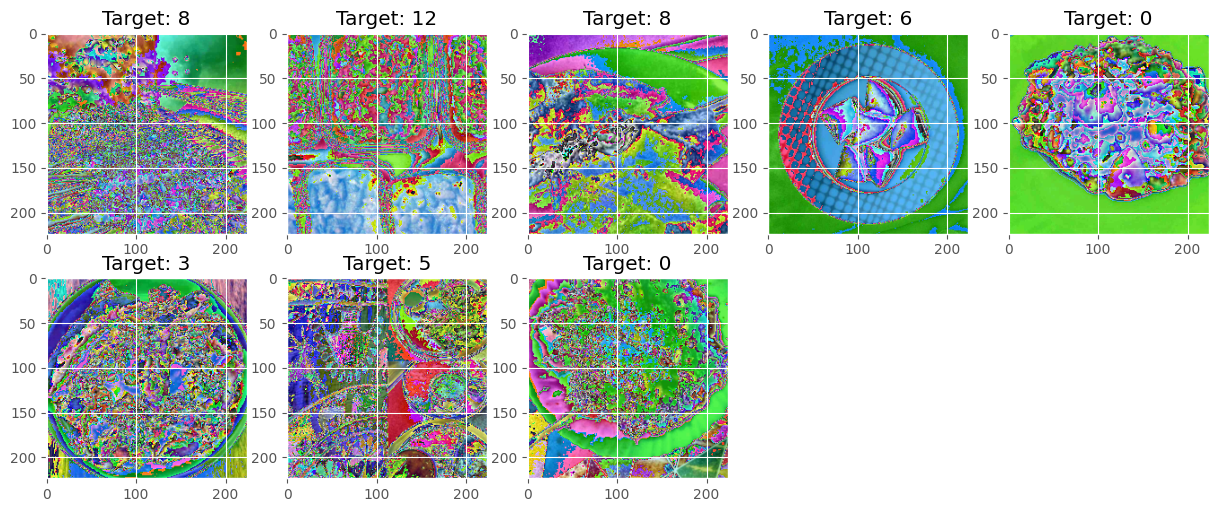

In [25]:
mean, std = get_mean_std(train_dataset, batch_size=8, num_workers=4)
print(mean, std)
# Define new transformations
new_transform = transforms.Compose([
    transforms.ToPILImage(),
    # transforms.RandomRotation(20),
    transforms.ToTensor(),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    # transforms.RandomCrop(28, padding=4),
    # transforms.PILToTensor(),
    # transforms.ConvertImageDtype(torch.float),
    # transforms.RandomPerspective(distortion_scale=0.6, p=1),
    # transforms.ColorJitter(brightness=.5, hue=.3),
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    transforms.Normalize(mean=mean, std=std)
])

# Apply transformation to the subset
transformed_subset = TransformedSubset(train_dataset, new_transform)

transformed_loader = torch.utils.data.DataLoader(
        transformed_subset,
        batch_size=8,
        shuffle=True,
        num_workers=4
    )


# Plot few images
plt.rcParams["figure.figsize"] = (15, 9)
plt.figure
for images, labels in transformed_loader:
    for i in range(len(labels)):
        plt.subplot(3, 5, i+1)
        img = Fn.to_pil_image(images[i])
        plt.imshow(img)
        plt.gca().set_title('Target: {0}'.format(labels[i]))
    plt.show()
    break

In [6]:
# animal_classes = [
#     'A', 'B', 'C', 'D', 'E', 
#     'F', 'G', 'H', 'I', 'J', 
#     'K', 'L', 'M' ]

In [7]:
# def add_data_embedings(dataset, tb_writer, n=100):
#     """
#     Add a few inputs and labels to tensorboard. 
#     """
    
#     dataloader = torch.utils.data.DataLoader(dataset, batch_size=n, num_workers=4, shuffle=True)
    
#     images, labels = next(iter(dataloader))
    
#     tb_writer.add_embedding(mat = images.view(-1, 3 * 224 * 224), 
#                             metadata=labels, 
#                             label_img=images)
    
#     return

In [8]:
# def get_data(batch_size, data_root, tb_writer, num_workers=4, data_augmentation=True):

#     preprocess = transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor()
#     ])
    
#     dataset =  KenyanFood13Dataset(data_root, image_shape=None, transform=preprocess)

#     train_size = int(0.8 * len(dataset)) # 80% for training
#     test_size = len(dataset) - train_size # 20% for validation
    
#     train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    
#     # dataloader with dataset
#     train_loader = torch.utils.data.DataLoader(
#         train_dataset,
#         batch_size=batch_size,
#         shuffle=True,
#         num_workers=num_workers
#     )

#     test_loader = torch.utils.data.DataLoader(
#         test_dataset, 
#         batch_size=batch_size, 
#         shuffle=False, 
#         num_workers=num_workers
#     )
    
#     # train_data_path = os.path.join(data_root, 'training')
       
#     # mean, std = get_mean_std()
    
#     # common_transforms = image_common_transforms(mean, std)
        
   
#     # if data_augmentation is true 
#     # data augmentation implementation
#     # if data_augmentation:    
#     #     train_transforms = data_augmentation_preprocess(mean, std)
#     # # else do common transforms
#     # else:
#     #     train_transforms = common_transforms
        
        
#     # train dataloader
    
#     # train_loader = data_loader(train_data_path, 
#     #                            train_transforms, 
#     #                            batch_size=batch_size, 
#     #                            shuffle=True, 
#     #                            num_workers=num_workers)
    
#     # test dataloader
    
#     # test_data_path = os.path.join(data_root, 'validation')
    
#     # test_loader = data_loader(test_data_path, 
#     #                           common_transforms, 
#     #                           batch_size=batch_size, 
#     #                           shuffle=False, 
#     #                           num_workers=num_workers)
    
#     # test dataloader
    
#     # testdata = datasets.ImageFolder(root=test_dataset)#, transform=common_transforms)
    
#     # # add embedding / projector
    
#     # add_data_embedings(testdata, tb_writer, n=100)
    
#     return train_loader, test_loader

## <font style="color:green">2. Configuration [5 Points]</font>

**Define your configuration here.**

For example:


```python
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 10 
    epochs_count: int = 50  
    init_learning_rate: float = 0.1  # initial learning rate for lr scheduler
    log_interval: int = 5  
    test_interval: int = 1  
    data_root: str = "/kaggle/input/opencv-pytorch-classification-project-2/" 
    num_workers: int = 2  
    device: str = 'cuda'  
    
```

## <font style="color:green">System Configuration</font><a name="sys-config"></a>

In [9]:
# @dataclass
# class SystemConfiguration:
#     '''
#     Describes the common system setting needed for reproducible training
#     '''
#     seed: int = 21  # seed number to set the state of all random number generators
#     cudnn_benchmark_enabled: bool = True  # enable CuDNN benchmark for the sake of performance
#     cudnn_deterministic: bool = True  # make cudnn deterministic (reproducible training)

## <font style="color:green">Training Configuration</font><a name="train-config"></a>

In [10]:
# @dataclass
# class TrainingConfiguration:
#     '''
#     Describes configuration of the training process
#     '''
#     batch_size: int = 5 #32  
#     epochs_count: int = 1 #20 
#     init_learning_rate: float = 0.001  # initial learning rate for lr scheduler
#     decay_rate: float = 0.1  
#     log_interval: int = 500  
#     test_interval: int = 1  
#     data_prefix: str = "../../../../data/Week7_project2_classification/"
#     data_root: str = os.path.join(data_prefix, "./KenyanFood13Dataset")
#     num_workers: int = 10  
#     device: str = 'cuda'  

In [11]:
# def setup_system(system_config: SystemConfiguration) -> None:
#     torch.manual_seed(system_config.seed)
#     if torch.cuda.is_available():
#         torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
#         torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

In [12]:
# def prediction(model, device, batch_input, max_prob=True):
#     """
#     get prediction for batch inputs
#     """
    
#     # send model to cpu/cuda according to your system configuration
#     model.to(device)
    
#     # it is important to do model.eval() before prediction
#     model.eval()

#     data = batch_input.to(device)

#     output = model(data)

#     # get probability score using softmax
#     prob = F.softmax(output, dim=1)
    
#     if max_prob:
#         # get the max probability
#         pred_prob = prob.data.max(dim=1)[0]
#     else:
#         pred_prob = prob.data
    
#     # get the index of the max probability
#     pred_index = prob.data.max(dim=1)[1]
    
#     return pred_index.cpu().numpy(), pred_prob.cpu().numpy()

In [13]:
# def get_target_and_prob(model, dataloader, device):
#     """
#     get targets and prediction probabilities
#     """
    
#     pred_prob = []
#     targets = []
    
#     for _, (data, target) in enumerate(dataloader):
        
#         _, prob = prediction(model, device, data, max_prob=False)
        
#         pred_prob.append(prob)
        
#         target = target.numpy()
#         targets.append(target)
        
#     targets = np.concatenate(targets)
#     targets = targets.astype(int)
#     pred_prob = np.concatenate(pred_prob, axis=0)
    
#     return targets, pred_prob
    
    

# <font style="color:blue">Add PR Curves to TensorBoard</font><a name="pr-curves"></a>

In [14]:
# def add_pr_curves_to_tensorboard(model, dataloader, device, tb_writer, epoch, num_classes=3):
#     """
#     Add precession and recall curve to tensorboard.
#     """
    
#     targets, pred_prob = get_target_and_prob(model, dataloader, device)
    
#     for cls_idx in range(num_classes):
#         binary_target = targets == cls_idx
#         true_prediction_prob = pred_prob[:, cls_idx]
        
#         tb_writer.add_pr_curve(animal_classes[cls_idx], 
#                                binary_target, 
#                                true_prediction_prob, 
#                                global_step=epoch)
        
#     return
    

# <font style="color:blue">Push Wrong Prediction to TensorBoard</font><a name="wrong-preds"></a>

In [15]:
# def add_wrong_prediction_to_tensorboard(model, dataloader, device, tb_writer, 
#                                         epoch, tag='Wrong_Predections', max_images='all'):
#     """
#     Add wrong predicted images to tensorboard.
#     """
#     #number of images in one row
#     num_images_per_row = 8
#     im_scale = 3
    
#     plot_images = []
#     wrong_labels = []
#     pred_prob = []
#     right_label = []
    
#     # mean, std = get_mean_std()
    
#     for _, (data, target) in enumerate(dataloader):
        
        
#         images = data.numpy()
#         pred, prob = prediction(model, device, data)
#         target = target.numpy()
#         indices = pred.astype(int) != target.astype(int)
        
#         plot_images.append(images[indices])
#         wrong_labels.append(pred[indices])
#         pred_prob.append(prob[indices])
#         right_label.append(target[indices])
        
#     plot_images = np.concatenate(plot_images, axis=0).squeeze()
#     plot_images = (np.moveaxis(plot_images, 1, -1))# * std) + mean
#     wrong_labels = np.concatenate(wrong_labels)
#     wrong_labels = wrong_labels.astype(int)
#     right_label = np.concatenate(right_label)
#     right_label = right_label.astype(int)
#     pred_prob = np.concatenate(pred_prob)
    
    
#     if max_images == 'all':
#         num_images = len(images)
#     else:
#         num_images = min(len(plot_images), max_images)
        
#     fig_width = num_images_per_row * im_scale
    
#     if num_images % num_images_per_row == 0:
#         num_row = num_images/num_images_per_row
#     else:
#         num_row = int(num_images/num_images_per_row) + 1
        
#     fig_height = num_row * im_scale
        
#     plt.style.use('default')
#     plt.rcParams["figure.figsize"] = (fig_width, fig_height)
#     fig = plt.figure()
    
#     for i in range(num_images):
#         plt.subplot(num_row, num_images_per_row, i+1, xticks=[], yticks=[])
#         plt.imshow((plot_images[i]*255).astype(np.uint8))
#         plt.gca().set_title('{0}({1:.2}), {2}'.format(animal_classes[wrong_labels[i]], 
#                                                           pred_prob[i], 
#                                                           animal_classes[right_label[i]]))
        
#     tb_writer.add_figure(tag, fig, global_step=epoch)
    
#     return


## <font style="color:green">3. Evaluation Metric [10 Points]</font>

**Define methods or classes that will be used in model evaluation. For example, accuracy, f1-score etc.**

## <font style="color:green">4. Train and Validation [5 Points]</font>


**Write the methods or classes to be used for training and validation.**

## <font style="color:green">Training Function</font><a name="train-fn"></a>

In [16]:
# def train(
#     train_config: TrainingConfiguration, model: nn.Module, optimizer: torch.optim.Optimizer,
#     train_loader: torch.utils.data.DataLoader, epoch_idx: int, tb_writer: SummaryWriter
# ) -> None:
    
#     # change model in training mode
#     model.train()
    
#     # to get batch loss
#     batch_loss = np.array([])
    
#     # to get batch accuracy
#     batch_acc = np.array([])
        
#     for batch_idx, (data, target) in enumerate(train_loader):
        
#         # clone target
#         indx_target = target.clone()
#         # send data to device (it is mandatory if GPU has to be used)
#         data = data.to(train_config.device)
#         # send target to device
#         target = target.to(train_config.device)

#         # reset parameters gradient to zero
#         optimizer.zero_grad()
        
#         # forward pass to the model
#         output = model(data)
        
#         # cross entropy loss
#         loss = F.cross_entropy(output, target)
        
#         # find gradients w.r.t training parameters
#         loss.backward()
#         # Update parameters using gradients
#         optimizer.step()
        
#         batch_loss = np.append(batch_loss, [loss.item()])
        
#         # get probability score using softmax
#         prob = F.softmax(output, dim=1)
            
#         # get the index of the max probability
#         pred = prob.data.max(dim=1)[1]  
                        
#         # correct prediction
#         correct = pred.cpu().eq(indx_target).sum()
            
#         # accuracy
#         acc = float(correct) / float(len(data))
        
#         batch_acc = np.append(batch_acc, [acc])

#         if batch_idx % train_config.log_interval == 0 and batch_idx > 0:
            
#             total_batch = epoch_idx * len(train_loader.dataset)/train_config.batch_size + batch_idx
#             tb_writer.add_scalar('Loss/train-batch', loss.item(), total_batch)
#             tb_writer.add_scalar('Accuracy/train-batch', acc, total_batch)
            
#     epoch_loss = batch_loss.mean()
#     epoch_acc = batch_acc.mean()
#     return epoch_loss, epoch_acc

## <font style="color:green">Validation Function</font><a name="validate-fn"></a>

In [17]:
# def validate(
#     train_config: TrainingConfiguration,
#     model: nn.Module,
#     test_loader: torch.utils.data.DataLoader
# ) -> float:
#     # 
#     model.eval()
#     test_loss = 0
#     count_corect_predictions = 0
#     for data, target in test_loader:
#         indx_target = target.clone()
#         data = data.to(train_config.device)
        
#         target = target.to(train_config.device)
        
#         output = model(data)
#         # add loss for each mini batch
#         test_loss += F.cross_entropy(output, target).item()
        
#         # get probability score using softmax
#         prob = F.softmax(output, dim=1)
        
#         # get the index of the max probability
#         pred = prob.data.max(dim=1)[1] 
        
#         # add correct prediction count
#         count_corect_predictions += pred.cpu().eq(indx_target).sum()

#     # average over number of mini-batches
#     test_loss = test_loss / len(test_loader)  
    
#     # average over number of dataset
#     accuracy = 100. * count_corect_predictions / len(test_loader.dataset)
    
#     return test_loss, accuracy/100.0

# <font style="color:blue">Add Histogram of Weights</font><a name="hist"></a>

In [18]:
# def add_model_weights_as_histogram(model, tb_writer, epoch):
#     for name, param in model.named_parameters():
#         tb_writer.add_histogram(name.replace('.', '/'), param.data.cpu().abs(), epoch)
#     return

# <font style="color:blue">Add Network Graph</font><a name="graph"></a>

In [19]:
# def add_network_graph_tensorboard(model, inputs, tb_writer):
#     tb_writer.add_graph(model, inputs)
#     return

Develop the Interface for the Train Function

## <font style="color:green">5. Model [5 Points]</font>

**Define your model in this section.**

**You are allowed to use any pre-trained model.**

In [20]:
# class BaseModel(nn.Module):
#     def __init__(self):
#         super().__init__()

#         # convolution layers
#         self._body = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2),
            
#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2),
#         )

        
#         # Fully connected layers
#         self._head = nn.Sequential(
#             nn.Linear(in_features=64*52*52, out_features=1024), 
#             nn.ReLU(inplace=True),
            
#             nn.Linear(in_features=1024, out_features=13)
            
#         )
    
#     def forward(self, x):
        
#         # apply feature extractor
#         x = self._body(x)
#         # flatten the output of conv layers
#         # dimension should be batch_size * number_of weight_in_last conv_layer
#         x = x.view(x.size()[0], -1)
#         # apply classification head
#         x = self._head(x)
        
        
#         return x


# <font style="color:blue">Transfer Learning</font><a name="graph"></a>

## <font style="color:green">Optimizer and Scheduler</font><a name="optim"></a>

We consider optimizer and scheduler to be a method because we use it in all training experiments.

In [21]:
# def get_optimizer_and_scheduler(model):
#     train_config = TrainingConfiguration()

#     init_learning_rate = train_config.init_learning_rate

#     # optimizer
#     optimizer = optim.SGD(
#         model.parameters(),
#         lr = init_learning_rate,
#         momentum = 0.9
#     )

#     decay_rate = train_config.decay_rate

#     lmbda = lambda epoch: 1/(1 + decay_rate * epoch)

#     # Scheduler
#     scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lmbda)
    
#     return optimizer, scheduler
    


# <font style="color:blue">ResNet Model</font><a name="model"></a>

Load the `resnet18` model with its pretrained weights.

The layers are configured such that if you pass the transfer_learning flag, it just replaces the last layers of the network. Otherwise, it will retrain all the layers, but with the pretrained weights, and not from scratch.

In [22]:
# def pretrained_resnet18(transfer_learning=True, num_class=3):
#     resnet = models.resnet18(pretrained=True)
#     # resnet = models.resnet18(weights=ResNet18_Weights.DEFAULT)
    
#     if transfer_learning:
#         for param in resnet.parameters():
#             param.requires_grad = False
            
#     last_layer_in = resnet.fc.in_features
#     resnet.fc = nn.Linear(last_layer_in, num_class)
    
#     return resnet

## <font style="color:green">6. Utils [5 Points]</font>

**Define those methods or classes, which have  not been covered in the above sections.**

Main Function

In [23]:
# def main(model, optimizer, tb_writer, scheduler=None, system_configuration=SystemConfiguration(), 
#          training_configuration=TrainingConfiguration(), data_augmentation=False):
    
#     # system configuration
#     setup_system(system_configuration)

#     # batch size
#     batch_size_to_set = training_configuration.batch_size
#     # num_workers
#     num_workers_to_set = training_configuration.num_workers
#     # epochs
#     epoch_num_to_set = training_configuration.epochs_count

#     # if GPU is available use training config, 
#     # else lower batch_size, num_workers and epochs count
#     if torch.cuda.is_available():
#         device = "cuda"
#     else:
#         device = "cpu"
#         batch_size_to_set = 16
#         num_workers_to_set = 2

#     # data loader
#     train_loader, test_loader = get_data(
#         batch_size=batch_size_to_set,
#         data_root=training_configuration.data_root,
#         tb_writer=tb_writer,
#         num_workers=num_workers_to_set,
#         data_augmentation=data_augmentation
#     )
    
    
#     # Update training configuration
#     training_configuration = TrainingConfiguration(
#         device=device,
#         batch_size=batch_size_to_set,
#         num_workers=num_workers_to_set
#     )
        
#     # send model to device (GPU/CPU)
#     model.to(training_configuration.device)
    
    
#     # add network graph with inputs info
#     images, labels = next(iter(test_loader))
#     images = images.to(training_configuration.device)
#     add_network_graph_tensorboard(model, images, tb_writer)

#     best_loss = torch.tensor(np.inf)
    
#     # epoch train/test loss
#     epoch_train_loss = np.array([])
#     epoch_test_loss = np.array([])
    
#     # epoch train/test accuracy
#     epoch_train_acc = np.array([])
#     epoch_test_acc = np.array([])
    
#     # add_wrong_prediction_to_tensorboard(model, test_loader, 
#     #                                             training_configuration.device, 
#     #                                             tb_writer, 0, max_images=300)
    
    
#     # training time measurement
#     t_begin = time.time()
#     for epoch in range(training_configuration.epochs_count):
        
#         # Traing
#         train_loss, train_acc = train(training_configuration, model, optimizer, train_loader, epoch, tb_writer)
        
#         epoch_train_loss = np.append(epoch_train_loss, [train_loss])
        
#         epoch_train_acc = np.append(epoch_train_acc, [train_acc])
        
#         # add scalar (loss/accuracy) to tensorboard
#         tb_writer.add_scalar('Loss/Train',train_loss, epoch)
#         tb_writer.add_scalar('Accuracy/Train', train_acc, epoch)

#         elapsed_time = time.time() - t_begin
#         speed_epoch = elapsed_time / (epoch + 1)
#         speed_batch = speed_epoch / len(train_loader)
#         eta = speed_epoch * training_configuration.epochs_count - elapsed_time
        
#         # add time metadata to tensorboard
#         tb_writer.add_scalar('Time/elapsed_time', elapsed_time, epoch)
#         tb_writer.add_scalar('Time/speed_epoch', speed_epoch, epoch)
#         tb_writer.add_scalar('Time/speed_batch', speed_batch, epoch)
#         tb_writer.add_scalar('Time/eta', eta, epoch)
        

#         # Validate
#         if epoch % training_configuration.test_interval == 0:
#             current_loss, current_accuracy = validate(training_configuration, model, test_loader)
            
#             epoch_test_loss = np.append(epoch_test_loss, [current_loss])
        
#             epoch_test_acc = np.append(epoch_test_acc, [current_accuracy])
            
#             # add scalar (loss/accuracy) to tensorboard
#             tb_writer.add_scalar('Loss/Validation', current_loss, epoch)
#             tb_writer.add_scalar('Accuracy/Validation', current_accuracy, epoch)
            
#             # add scalars (loss/accuracy) to tensorboard
#             tb_writer.add_scalars('Loss/train-val', {'train': train_loss, 
#                                            'validation': current_loss}, epoch)
#             tb_writer.add_scalars('Accuracy/train-val', {'train': train_acc, 
#                                                'validation': current_accuracy}, epoch)
            
#             if current_loss < best_loss:
#                 best_loss = current_loss
                
#             # add wrong predicted image to tensorboard
#             # add_wrong_prediction_to_tensorboard(model, test_loader, 
#             #                                     training_configuration.device, 
#             #                                     tb_writer, epoch, max_images=300)
        
#         # scheduler step/ update learning rate
#         if scheduler is not None:
#             scheduler.step()
            
#         # adding model weights to tensorboard as histogram
#         add_model_weights_as_histogram(model, tb_writer, epoch)
        
#         # add pr curves to tensor board
#         add_pr_curves_to_tensorboard(model, test_loader, 
#                                      training_configuration.device, 
#                                      tb_writer, epoch, num_classes=3)
        
                
#     print("Total time: {:.2f}, Best Loss: {:.3f}".format(time.time() - t_begin, best_loss))
    
    
    
#     return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

## <font style="color:green">7. Experiment [5 Points]</font>

**Choose your optimizer and LR-scheduler and use the above methods and classes to train your model.**

In [24]:
# def get_optimizer_and_scheduler(model):
#     train_config = TrainingConfiguration()

#     init_learning_rate = train_config.init_learning_rate

#     # optimizer
#     optimizer = optim.SGD(
#         model.parameters(),
#         lr = init_learning_rate,
#         momentum = 0.9
#     )

#     decay_rate = train_config.decay_rate

#     lmbda = lambda epoch: 1/(1 + decay_rate * epoch)

#     # Scheduler
#     scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lmbda)
    
#     return optimizer, scheduler
    


# <font style="color:blue">Base Model</font><a name="tl"></a>

In [25]:
# model = BaseModel()
# print(model)
# # optimizer
# optimizer = optim.Adam(
#     model.parameters(),
#     lr = 0.001,
#     betas=(0.9, 0.999),
#     eps=1e-08,
#     weight_decay=0, #turn
#     amsgrad=False
# )

# decay_rate = 0.9
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=decay_rate)

# training_configuration=TrainingConfiguration()
# # Tensorboard summary writer
# base_model_sw = SummaryWriter(os.path.join(training_configuration.data_prefix, 'log_basemodel/base_model'))

# model, train_loss_exp9, train_acc_exp9, val_loss_exp9, val_acc_exp9 = main(model, 
#                                                                            optimizer, 
#                                                                            base_model_sw,
#                                                                            scheduler,
#                                                                            data_augmentation=True)

# base_model_sw.close()

# <font style="color:blue">ResNet Model Transfer Learning</font><a name="tl"></a>

In [26]:
# model = pretrained_resnet18(transfer_learning=True, num_class=13)
# # print(model)
# # get optimizer and scheduler
# optimizer, scheduler = get_optimizer_and_scheduler(model)


# training_configuration=TrainingConfiguration()
# # Tensorboard summary writer
# transfer_learning_sw = SummaryWriter(os.path.join(training_configuration.data_prefix, 'log_resnet18/base_model'))


# # train and validate
# model, train_loss_exp2, train_acc_exp2, val_loss_exp2, val_acc_exp2 = main(model, 
#                                                                            optimizer,
#                                                                            transfer_learning_sw,
#                                                                            scheduler,
#                                                                            data_augmentation=True)
# transfer_learning_sw.close()

# <font style="color:blue">ResNet Model Transfer Learning - Fine Tuning</font><a name="tl"></a>

In [27]:
# model = pretrained_resnet18(transfer_learning=False, num_class=13)
# # print(model)
# # get optimizer and scheduler
# optimizer, scheduler = get_optimizer_and_scheduler(model)

# training_configuration=TrainingConfiguration()
# # Tensorboard summary writer
# fine_tuning_sw = SummaryWriter(os.path.join(training_configuration.data_prefix, 'log_resnet18/fine_tuning_model'))


# model, train_loss_exp9, train_acc_exp9, val_loss_exp9, val_acc_exp9 = main(model, 
#                                                                            optimizer, 
#                                                                            fine_tuning_sw,
#                                                                            scheduler,
#                                                                            data_augmentation=True)

# fine_tuning_sw.close()

## <font style="color:green">8. TensorBoard Log [5 Points]</font>

**Share your TensorBoard scalars logs here You can also share (not mandatory) your GitHub link, if you have pushed this project in GitHub.**


<font style="color:red">Note:</font> In light of the recent shutdown of tensorboard.dev, we have updated the submission requirements for your project. Instead of sharing a tensorboard.dev link, you are now required to upload your generated TensorBoard event files directly onto the lab. As an alternative, you may also include a screenshot of your TensorBoard output within your Jupyter notebook. This adjustment ensures that your data visualization and model training efforts are thoroughly documented and accessible for evaluation.

## <font style="color:green">9. Kaggle Profile Link [50 Points]</font>

**Share your Kaggle profile link  with us here to score , points in  the competition.**

**For full points, you need a minimum accuracy of `75%` on the test data. If accuracy is less than `70%`, you gain  no points for this section.**


**Submit `submission.csv` (prediction for images in `test.csv`), in the `Submit Predictions` tab in Kaggle, to get evaluated for  this section.**